In [104]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [105]:
pip install preprocessing

Note: you may need to restart the kernel to use updated packages.


In [106]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2018, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-05,175.369995,173.050003,173.440002,175.000000,23660000.0,170.369385
2018-01-08,175.610001,173.929993,174.350006,174.350006,20567800.0,169.736588
2018-01-09,175.059998,173.410004,174.550003,174.330002,21584000.0,169.717117
2018-01-10,174.300003,173.000000,173.160004,174.289993,23959900.0,169.678162
2018-01-11,175.490005,174.490005,174.589996,175.279999,18667700.0,170.641968


In [107]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [108]:
mavg.tail(10)

Date
2017-12-28    159.204700
2017-12-29    159.305436
2018-01-02    159.426200
2018-01-03    159.596242
2018-01-04    159.753119
2018-01-05    159.906184
2018-01-08    160.035946
2018-01-09    160.171818
2018-01-10    160.337276
2018-01-11    160.515863
Name: Adj Close, dtype: float64

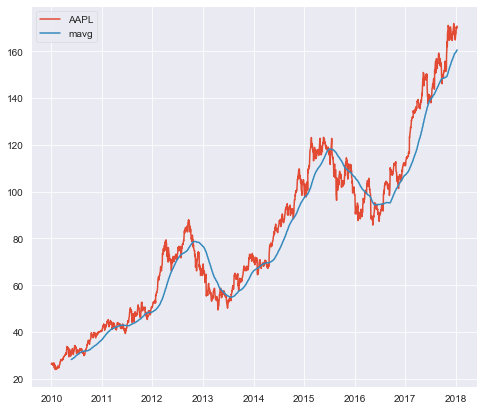

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(8, 7))
sns.set_style("darkgrid")
plt.plot(close_px,label='AAPL')
plt.plot(mavg,label='mavg')
plt.legend()


In [110]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [111]:
import numpy as np
import math
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import scale
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [114]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Lasso())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [115]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
print('The linear regression confidence is ',confidencereg)
print('The quadratic regression 2 confidence is ',confidencepoly2)
print('The quadratic regression 3 confidence is ',confidencepoly3)
print('The knn regression confidence is ',confidenceknn)

The linear regression confidence is  0.972392726638451
The quadratic regression 2 confidence is  0.9728396778181093
The quadratic regression 3 confidence is  0.9713842938728099
The knn regression confidence is  0.957992495302561


In [116]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan


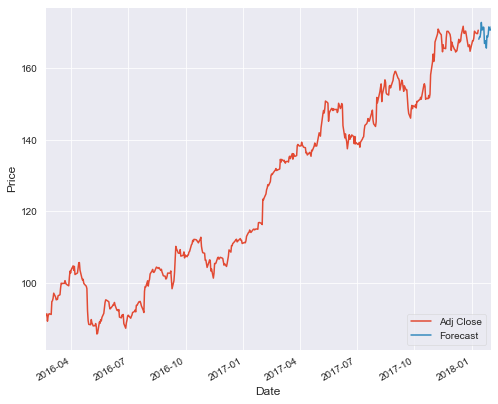

In [117]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()